# Typical Set Initialization

Stan's MCMC algorithm warms up with an initial fast adaptation interval with default length of 75 iterations.  In these first 75 iterations, "the chain is allowed to converge towards the typical set", see [Stan documentation, Section Automatic Parameter Tuning](https://mc-stan.org/docs/reference-manual/hmc-algorithm-parameters.html#automatic-parameter-tuning).  This notebook proposes a new initialization scheme which uses on average fewer gradient evaluations within 75 warmup iterations to move nearly the same distance toward the typical set.

During the 75 warm up iterations of the initial fast interval, Stan's dynamic HMC leapfrogs through phase space, numerically integrating a Hamiltonian system of equations and then selects a new point ensuring detailed balance holds.  The leapfrog steps ensure progress toward the typical set, while preserving detailed balance provides some sort of asymptotic guarantee on expectation values (if sampling were to continue indefinitely).  Since these warmup iterations are commonly thrown away, this author believes there is an argument against spending the computational resources to preserve detailed balance.

In the most common use case of Stan, the initial 75 warmup iterations are to find the typical set, not to provide information about expectation values.  This notebook explores the computational gain, if any, to be had in giving up detailed balance during these initial 75 warmup iterations.

Similar to Stan, this initialization scheme 

* adapts the step size based on the change in the [Hamiltonian](https://mc-stan.org/docs/reference-manual/hamiltonian-monte-carlo.html#the-hamiltonian) from the initial point to the point reached by leapfrog steps,
* initializes parameter values $\theta \in \mathbb{R}^D$ with $U_d(-2, 2)$ draws for $d = 1:D$, such that the log_density and its gradient are finite
* limits the maximum number of leapfrog steps to $2^{10}$ by default
* calculates divergences and aborts trajectories if a divergence is reached before a u-turn

Different from Stan, this initialization scheme

* ignores detailed balance by stopping leapfrog steps when a u-turn is reached
* the final position upon a u-turn is always accepted, given no divergence occured

## Algorithm details

**input**: log_density_gradient() for a Stan program, dimension D

**output**: a point in parameter space as close to the typical set as Stan might produce

1. initialize $\theta$ from $U(-2, 2)$ until log_density and gradient are finite
2. initialize step_size
3. direction ~ U({-1, 1})
4. for step in 1:75
    * while n_leapfrog < max_leapfrogs
        * n_leapfrog += 1
        * position' = leapfrog(position, ..., direction, ...)
        * calculate change in Hamiltonian
        * if divergent: break
        * if u_turn: break
    * update step_size
    * if not divergent: position' = position

In [1]:
from cmdstanpy import CmdStanModel
from initialize import initialize # the proposed intialization procedure
from pathlib import Path

import bridgestan as bs
bs.set_bridgestan_path(Path.home() / "bridgestan")

import matplotlib.pyplot as plt
import numpy as np

/Users/girlfriend/venvs/py3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [13]:
# model = "earnings-earn_height" # typical set is far away
model = "arma-arma11"
stan_file = Path.home() / "minipdb" / "programs" / model / (model + ".stan")
data_file = Path.home() / "minipdb" / "programs" / model / (model + ".json")

bsm = bs.StanModel(stan_file, data_file)
dim = bsm.param_unc_num()

def ldg(position, gradient):
    ld = -np.inf
    try:
        ld, _ = bsm.log_density_gradient(position, out = gradient)
    except:
        pass
    return ld

In [14]:
M = 100 # number of simulations
degrees_before_cut_off = 75
cut_off = np.cos(degrees_before_cut_off * np.pi / 180)

stan_leapfrogs = np.zeros(M)
new_leapfrogs = np.zeros(M)

stan_params = np.zeros(shape = (M, dim))
new_params = np.zeros(shape = (M, dim))

q_uturns = np.zeros(M)
p_uturns = np.zeros(M)
o_uturns = np.zeros(M)

csm = CmdStanModel(stan_file = stan_file)

for m in range(M):
    rng = np.random.default_rng()
    fit_new = initialize(rng, dim, ldg, 
                         steps = steps, 
                         max_leapfrogs = max_leapfrogs,
                         cut_off = cut_off)
    new_leapfrogs[m] = np.sum(fit_new["number_leapfrogs"])
    new_params[m, :] = fit_new["position"]
    q_uturns[m] = fit_new["position_uturn"]
    p_uturns[m] = fit_new["momentum_uturn"]  
    o_uturns[m] = fit_new["either_uturn"]
    
    fit_stan = csm.sample(data = str(data_file),
                     save_warmup = True,
                     iter_sampling = 0,
                     iter_warmup = 100,
                     chains = 1)
    df_draws = fit_stan.draws_pd(inc_warmup = True)
    stan_leapfrogs[m] = np.sum(df_draws["n_leapfrog__"][:steps])
    l = len(df_draws.columns)
    q = df_draws.iloc[steps, (l - dim):l].values.copy()
    stan_params[m, :] = bsm.param_unconstrain(q)

15:36:29 - cmdstanpy - INFO - CmdStan start processing
chain 1 |███████████████████████████████████████████████████████████████████████| 00:00 Sampling completed


15:36:29 - cmdstanpy - INFO - CmdStan done processing.
15:36:29 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/girlfriend/minipdb/programs/arma-arma11/arma-arma11.stan', line 31, column 2 to column 25)
Consider re-running with show_console=True if the above output is unclear!
/Users/girlfriend/typical-init/tools.py:7: RuntimeWarning: invalid value encountered in scalar divide
  f = np.dot(pf, pt) / (normf * normt)
/Users/girlfriend/typical-init/tools.py:8: RuntimeWarning: invalid value encountered in scalar divide
  b = np.dot(pb, pt) / (normb * normt)
15:36:29 - cmdstanpy - INFO - CmdStan start processing


chain 1 |███████████████████████████████████████████████████████████████████████| 00:00 Sampling completed


15:36:29 - cmdstanpy - INFO - CmdStan done processing.
15:36:29 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/girlfriend/minipdb/programs/arma-arma11/arma-arma11.stan', line 31, column 2 to column 25)
Consider re-running with show_console=True if the above output is unclear!
15:36:29 - cmdstanpy - INFO - CmdStan start processing


chain 1 |███████████████████████████████████████████████████████████████████████| 00:00 Sampling completed


15:36:29 - cmdstanpy - INFO - CmdStan done processing.


15:36:29 - cmdstanpy - INFO - CmdStan start processing
chain 1 |███████████████████████████████████████████████████████████████████████| 00:00 Sampling completed


15:36:29 - cmdstanpy - INFO - CmdStan done processing.


15:36:30 - cmdstanpy - INFO - CmdStan start processing
chain 1 |███████████████████████████████████████████████████████████████████████| 00:00 Sampling completed


15:36:30 - cmdstanpy - INFO - CmdStan done processing.


15:36:30 - cmdstanpy - INFO - CmdStan start processing
chain 1 |███████████████████████████████████████████████████████████████████████| 00:00 Sampling completed


15:36:30 - cmdstanpy - INFO - CmdStan done processing.


15:36:30 - cmdstanpy - INFO - CmdStan start processing
chain 1 |███████████████████████████████████████████████████████████████████████| 00:00 Sampling completed


15:36:30 - cmdstanpy - INFO - CmdStan done processing.


15:36:30 - cmdstanpy - INFO - CmdStan start processing
chain 1 |███████████████████████████████████████████████████████████████████████| 00:00 Sampling completed


15:36:30 - cmdstanpy - INFO - CmdStan done processing.
/Users/girlfriend/typical-init/tools.py:7: RuntimeWarning: invalid value encountered in scalar divide
  f = np.dot(pf, pt) / (normf * normt)
/Users/girlfriend/typical-init/tools.py:8: RuntimeWarning: invalid value encountered in scalar divide
  b = np.dot(pb, pt) / (normb * normt)
15:36:30 - cmdstanpy - INFO - CmdStan start processing


chain 1 |███████████████████████████████████████████████████████████████████████| 00:00 Sampling completed


15:36:30 - cmdstanpy - INFO - CmdStan done processing.


15:36:30 - cmdstanpy - INFO - CmdStan start processing
chain 1 |███████████████████████████████████████████████████████████████████████| 00:00 Sampling completed


15:36:30 - cmdstanpy - INFO - CmdStan done processing.
/Users/girlfriend/typical-init/tools.py:7: RuntimeWarning: invalid value encountered in scalar divide
  f = np.dot(pf, pt) / (normf * normt)
/Users/girlfriend/typical-init/tools.py:8: RuntimeWarning: invalid value encountered in scalar divide
  b = np.dot(pb, pt) / (normb * normt)
15:36:30 - cmdstanpy - INFO - CmdStan start processing


chain 1 |███████████████████████████████████████████████████████████████████████| 00:00 Sampling completed


15:36:30 - cmdstanpy - INFO - CmdStan done processing.
/Users/girlfriend/typical-init/tools.py:7: RuntimeWarning: invalid value encountered in scalar divide
  f = np.dot(pf, pt) / (normf * normt)
/Users/girlfriend/typical-init/tools.py:8: RuntimeWarning: invalid value encountered in scalar divide
  b = np.dot(pb, pt) / (normb * normt)
15:36:30 - cmdstanpy - INFO - CmdStan start processing


chain 1 |███████████████████████████████████████████████████████████████████████| 00:00 Sampling completed


15:36:30 - cmdstanpy - INFO - CmdStan done processing.
15:36:30 - cmdstanpy - INFO - CmdStan start processing


chain 1 |███████████████████████████████████████████████████████████████████████| 00:00 Sampling completed


15:36:30 - cmdstanpy - INFO - CmdStan done processing.
15:36:30 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/girlfriend/minipdb/programs/arma-arma11/arma-arma11.stan', line 31, column 2 to column 25)
Consider re-running with show_console=True if the above output is unclear!


15:36:30 - cmdstanpy - INFO - CmdStan start processing
chain 1 |███████████████████████████████████████████████████████████████████████| 00:00 Sampling completed


15:36:30 - cmdstanpy - INFO - CmdStan done processing.
15:36:30 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/girlfriend/minipdb/programs/arma-arma11/arma-arma11.stan', line 31, column 2 to column 25)
Consider re-running with show_console=True if the above output is unclear!
/Users/girlfriend/typical-init/tools.py:7: RuntimeWarning: invalid value encountered in scalar divide
  f = np.dot(pf, pt) / (normf * normt)
/Users/girlfriend/typical-init/tools.py:8: RuntimeWarning: invalid value encountered in scalar divide
  b = np.dot(pb, pt) / (normb * normt)


15:36:30 - cmdstanpy - INFO - CmdStan start processing
chain 1 |███████████████████████████████████████████████████████████████████████| 00:00 Sampling completed


15:36:30 - cmdstanpy - INFO - CmdStan done processing.
15:36:30 - cmdstanpy - INFO - CmdStan start processing


chain 1 |███████████████████████████████████████████████████████████████████████| 00:00 Sampling completed


15:36:31 - cmdstanpy - INFO - CmdStan done processing.
15:36:31 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/girlfriend/minipdb/programs/arma-arma11/arma-arma11.stan', line 31, column 2 to column 25)
Consider re-running with show_console=True if the above output is unclear!


15:36:31 - cmdstanpy - INFO - CmdStan start processing
chain 1 |███████████████████████████████████████████████████████████████████████| 00:00 Sampling completed


15:36:31 - cmdstanpy - INFO - CmdStan done processing.


15:36:31 - cmdstanpy - INFO - CmdStan start processing
chain 1 |███████████████████████████████████████████████████████████████████████| 00:00 Sampling completed


15:36:31 - cmdstanpy - INFO - CmdStan done processing.
15:36:31 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/girlfriend/minipdb/programs/arma-arma11/arma-arma11.stan', line 31, column 2 to column 25)
Consider re-running with show_console=True if the above output is unclear!


15:36:31 - cmdstanpy - INFO - CmdStan start processing
chain 1 |███████████████████████████████████████████████████████████████████████| 00:00 Sampling completed


15:36:31 - cmdstanpy - INFO - CmdStan done processing.


15:36:31 - cmdstanpy - INFO - CmdStan start processing
chain 1 |███████████████████████████████████████████████████████████████████████| 00:00 Sampling completed


15:36:31 - cmdstanpy - INFO - CmdStan done processing.


15:36:31 - cmdstanpy - INFO - CmdStan start processing
chain 1 |███████████████████████████████████████████████████████████████████████| 00:00 Sampling completed


15:36:31 - cmdstanpy - INFO - CmdStan done processing.


15:36:31 - cmdstanpy - INFO - CmdStan start processing
chain 1 |███████████████████████████████████████████████████████████████████████| 00:00 Sampling completed


15:36:31 - cmdstanpy - INFO - CmdStan done processing.
/Users/girlfriend/typical-init/tools.py:7: RuntimeWarning: invalid value encountered in scalar divide
  f = np.dot(pf, pt) / (normf * normt)
/Users/girlfriend/typical-init/tools.py:8: RuntimeWarning: invalid value encountered in scalar divide
  b = np.dot(pb, pt) / (normb * normt)
15:36:31 - cmdstanpy - INFO - CmdStan start processing


chain 1 |███████████████████████████████████████████████████████████████████████| 00:00 Sampling completed


15:36:31 - cmdstanpy - INFO - CmdStan done processing.
15:36:31 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/girlfriend/minipdb/programs/arma-arma11/arma-arma11.stan', line 31, column 2 to column 25)
Consider re-running with show_console=True if the above output is unclear!


15:36:31 - cmdstanpy - INFO - CmdStan start processing
chain 1 |███████████████████████████████████████████████████████████████████████| 00:00 Sampling completed


15:36:31 - cmdstanpy - INFO - CmdStan done processing.
/Users/girlfriend/typical-init/tools.py:7: RuntimeWarning: invalid value encountered in scalar divide
  f = np.dot(pf, pt) / (normf * normt)
/Users/girlfriend/typical-init/tools.py:8: RuntimeWarning: invalid value encountered in scalar divide
  b = np.dot(pb, pt) / (normb * normt)
15:36:31 - cmdstanpy - INFO - CmdStan start processing


chain 1 |███████████████████████████████████████████████████████████████████████| 00:00 Sampling completed


15:36:31 - cmdstanpy - INFO - CmdStan done processing.
15:36:31 - cmdstanpy - INFO - CmdStan start processing


chain 1 |███████████████████████████████████████████████████████████████████████| 00:00 Sampling completed


15:36:31 - cmdstanpy - INFO - CmdStan done processing.
15:36:31 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/girlfriend/minipdb/programs/arma-arma11/arma-arma11.stan', line 31, column 2 to column 25)
Consider re-running with show_console=True if the above output is unclear!


15:36:32 - cmdstanpy - INFO - CmdStan start processing
chain 1 |███████████████████████████████████████████████████████████████████████| 00:00 Sampling completed


15:36:32 - cmdstanpy - INFO - CmdStan done processing.
/Users/girlfriend/typical-init/tools.py:7: RuntimeWarning: invalid value encountered in scalar divide
  f = np.dot(pf, pt) / (normf * normt)
/Users/girlfriend/typical-init/tools.py:8: RuntimeWarning: invalid value encountered in scalar divide
  b = np.dot(pb, pt) / (normb * normt)
15:36:32 - cmdstanpy - INFO - CmdStan start processing


chain 1 |███████████████████████████████████████████████████████████████████████| 00:00 Sampling completed


15:36:32 - cmdstanpy - INFO - CmdStan done processing.
/Users/girlfriend/typical-init/tools.py:7: RuntimeWarning: invalid value encountered in scalar divide
  f = np.dot(pf, pt) / (normf * normt)
/Users/girlfriend/typical-init/tools.py:8: RuntimeWarning: invalid value encountered in scalar divide
  b = np.dot(pb, pt) / (normb * normt)
15:36:32 - cmdstanpy - INFO - CmdStan start processing


chain 1 |███████████████████████████████████████████████████████████████████████| 00:00 Sampling completed


15:36:32 - cmdstanpy - INFO - CmdStan done processing.


15:36:32 - cmdstanpy - INFO - CmdStan start processing
chain 1 |███████████████████████████████████████████████████████████████████████| 00:00 Sampling completed


15:36:32 - cmdstanpy - INFO - CmdStan done processing.
/Users/girlfriend/typical-init/tools.py:7: RuntimeWarning: invalid value encountered in scalar divide
  f = np.dot(pf, pt) / (normf * normt)
/Users/girlfriend/typical-init/tools.py:8: RuntimeWarning: invalid value encountered in scalar divide
  b = np.dot(pb, pt) / (normb * normt)


15:36:32 - cmdstanpy - INFO - CmdStan start processing
chain 1 |███████████████████████████████████████████████████████████████████████| 00:00 Sampling completed


15:36:32 - cmdstanpy - INFO - CmdStan done processing.
15:36:32 - cmdstanpy - INFO - CmdStan start processing


chain 1 |███████████████████████████████████████████████████████████████████████| 00:00 Sampling completed


15:36:32 - cmdstanpy - INFO - CmdStan done processing.
/Users/girlfriend/typical-init/tools.py:7: RuntimeWarning: invalid value encountered in scalar divide
  f = np.dot(pf, pt) / (normf * normt)
/Users/girlfriend/typical-init/tools.py:8: RuntimeWarning: invalid value encountered in scalar divide
  b = np.dot(pb, pt) / (normb * normt)
15:36:32 - cmdstanpy - INFO - CmdStan start processing


chain 1 |███████████████████████████████████████████████████████████████████████| 00:00 Sampling completed


15:36:32 - cmdstanpy - INFO - CmdStan done processing.
15:36:32 - cmdstanpy - INFO - CmdStan start processing


chain 1 |███████████████████████████████████████████████████████████████████████| 00:00 Sampling completed


15:36:32 - cmdstanpy - INFO - CmdStan done processing.
/Users/girlfriend/typical-init/tools.py:7: RuntimeWarning: invalid value encountered in scalar divide
  f = np.dot(pf, pt) / (normf * normt)
/Users/girlfriend/typical-init/tools.py:8: RuntimeWarning: invalid value encountered in scalar divide
  b = np.dot(pb, pt) / (normb * normt)
15:36:32 - cmdstanpy - INFO - CmdStan start processing


chain 1 |███████████████████████████████████████████████████████████████████████| 00:00 Sampling completed


15:36:32 - cmdstanpy - INFO - CmdStan done processing.
15:36:32 - cmdstanpy - INFO - CmdStan start processing


chain 1 |███████████████████████████████████████████████████████████████████████| 00:00 Sampling completed


15:36:32 - cmdstanpy - INFO - CmdStan done processing.
15:36:32 - cmdstanpy - INFO - CmdStan start processing


chain 1 |███████████████████████████████████████████████████████████████████████| 00:00 Sampling completed


15:36:32 - cmdstanpy - INFO - CmdStan done processing.
15:36:32 - cmdstanpy - INFO - CmdStan start processing


chain 1 |███████████████████████████████████████████████████████████████████████| 00:00 Sampling completed


15:36:32 - cmdstanpy - INFO - CmdStan done processing.
/Users/girlfriend/typical-init/tools.py:7: RuntimeWarning: invalid value encountered in scalar divide
  f = np.dot(pf, pt) / (normf * normt)
/Users/girlfriend/typical-init/tools.py:8: RuntimeWarning: invalid value encountered in scalar divide
  b = np.dot(pb, pt) / (normb * normt)
15:36:32 - cmdstanpy - INFO - CmdStan start processing


chain 1 |███████████████████████████████████████████████████████████████████████| 00:00 Sampling completed


15:36:32 - cmdstanpy - INFO - CmdStan done processing.


15:36:33 - cmdstanpy - INFO - CmdStan start processing
chain 1 |███████████████████████████████████████████████████████████████████████| 00:00 Sampling completed


15:36:33 - cmdstanpy - INFO - CmdStan done processing.


15:36:33 - cmdstanpy - INFO - CmdStan start processing
chain 1 |███████████████████████████████████████████████████████████████████████| 00:00 Sampling completed


15:36:33 - cmdstanpy - INFO - CmdStan done processing.


15:36:33 - cmdstanpy - INFO - CmdStan start processing
chain 1 |███████████████████████████████████████████████████████████████████████| 00:00 Sampling completed


15:36:33 - cmdstanpy - INFO - CmdStan done processing.


15:36:33 - cmdstanpy - INFO - CmdStan start processing
chain 1 |███████████████████████████████████████████████████████████████████████| 00:00 Sampling completed


15:36:33 - cmdstanpy - INFO - CmdStan done processing.


15:36:33 - cmdstanpy - INFO - CmdStan start processing
chain 1 |███████████████████████████████████████████████████████████████████████| 00:00 Sampling completed


15:36:33 - cmdstanpy - INFO - CmdStan done processing.


15:36:33 - cmdstanpy - INFO - CmdStan start processing
chain 1 |███████████████████████████████████████████████████████████████████████| 00:00 Sampling completed


15:36:33 - cmdstanpy - INFO - CmdStan done processing.
15:36:33 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/girlfriend/minipdb/programs/arma-arma11/arma-arma11.stan', line 31, column 2 to column 25)
Consider re-running with show_console=True if the above output is unclear!
15:36:33 - cmdstanpy - INFO - CmdStan start processing


chain 1 |███████████████████████████████████████████████████████████████████████| 00:00 Sampling completed


15:36:33 - cmdstanpy - INFO - CmdStan done processing.
/Users/girlfriend/typical-init/tools.py:7: RuntimeWarning: invalid value encountered in scalar divide
  f = np.dot(pf, pt) / (normf * normt)
/Users/girlfriend/typical-init/tools.py:8: RuntimeWarning: invalid value encountered in scalar divide
  b = np.dot(pb, pt) / (normb * normt)


15:36:33 - cmdstanpy - INFO - CmdStan start processing
chain 1 |███████████████████████████████████████████████████████████████████████| 00:00 Sampling completed


15:36:33 - cmdstanpy - INFO - CmdStan done processing.
15:36:33 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/girlfriend/minipdb/programs/arma-arma11/arma-arma11.stan', line 31, column 2 to column 25)
Consider re-running with show_console=True if the above output is unclear!
/Users/girlfriend/typical-init/tools.py:7: RuntimeWarning: invalid value encountered in scalar divide
  f = np.dot(pf, pt) / (normf * normt)
/Users/girlfriend/typical-init/tools.py:8: RuntimeWarning: invalid value encountered in scalar divide
  b = np.dot(pb, pt) / (normb * normt)


15:36:33 - cmdstanpy - INFO - CmdStan start processing
chain 1 |███████████████████████████████████████████████████████████████████████| 00:00 Sampling completed


15:36:33 - cmdstanpy - INFO - CmdStan done processing.


15:36:33 - cmdstanpy - INFO - CmdStan start processing
chain 1 |███████████████████████████████████████████████████████████████████████| 00:00 Sampling completed


15:36:33 - cmdstanpy - INFO - CmdStan done processing.


15:36:33 - cmdstanpy - INFO - CmdStan start processing
chain 1 |███████████████████████████████████████████████████████████████████████| 00:00 Sampling completed


15:36:33 - cmdstanpy - INFO - CmdStan done processing.
/Users/girlfriend/typical-init/tools.py:7: RuntimeWarning: invalid value encountered in scalar divide
  f = np.dot(pf, pt) / (normf * normt)
/Users/girlfriend/typical-init/tools.py:8: RuntimeWarning: invalid value encountered in scalar divide
  b = np.dot(pb, pt) / (normb * normt)


15:36:34 - cmdstanpy - INFO - CmdStan start processing
chain 1 |███████████████████████████████████████████████████████████████████████| 00:00 Sampling completed


15:36:34 - cmdstanpy - INFO - CmdStan done processing.
15:36:34 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/girlfriend/minipdb/programs/arma-arma11/arma-arma11.stan', line 31, column 2 to column 25)
Consider re-running with show_console=True if the above output is unclear!


15:36:34 - cmdstanpy - INFO - CmdStan start processing
chain 1 |███████████████████████████████████████████████████████████████████████| 00:00 Sampling completed


15:36:34 - cmdstanpy - INFO - CmdStan done processing.


15:36:34 - cmdstanpy - INFO - CmdStan start processing
chain 1 |███████████████████████████████████████████████████████████████████████| 00:00 Sampling completed


15:36:34 - cmdstanpy - INFO - CmdStan done processing.
/Users/girlfriend/typical-init/tools.py:7: RuntimeWarning: invalid value encountered in scalar divide
  f = np.dot(pf, pt) / (normf * normt)
/Users/girlfriend/typical-init/tools.py:8: RuntimeWarning: invalid value encountered in scalar divide
  b = np.dot(pb, pt) / (normb * normt)


15:36:34 - cmdstanpy - INFO - CmdStan start processing
chain 1 |███████████████████████████████████████████████████████████████████████| 00:00 Sampling completed


15:36:34 - cmdstanpy - INFO - CmdStan done processing.


15:36:34 - cmdstanpy - INFO - CmdStan start processing
chain 1 |███████████████████████████████████████████████████████████████████████| 00:00 Sampling completed


15:36:34 - cmdstanpy - INFO - CmdStan done processing.
/Users/girlfriend/typical-init/tools.py:7: RuntimeWarning: invalid value encountered in scalar divide
  f = np.dot(pf, pt) / (normf * normt)
/Users/girlfriend/typical-init/tools.py:8: RuntimeWarning: invalid value encountered in scalar divide
  b = np.dot(pb, pt) / (normb * normt)


15:36:34 - cmdstanpy - INFO - CmdStan start processing
chain 1 |███████████████████████████████████████████████████████████████████████| 00:00 Sampling completed


15:36:34 - cmdstanpy - INFO - CmdStan done processing.


15:36:34 - cmdstanpy - INFO - CmdStan start processing
chain 1 |███████████████████████████████████████████████████████████████████████| 00:00 Sampling completed


15:36:34 - cmdstanpy - INFO - CmdStan done processing.
15:36:34 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/girlfriend/minipdb/programs/arma-arma11/arma-arma11.stan', line 31, column 2 to column 25)
Consider re-running with show_console=True if the above output is unclear!
15:36:34 - cmdstanpy - INFO - CmdStan start processing


chain 1 |███████████████████████████████████████████████████████████████████████| 00:00 Sampling completed


15:36:34 - cmdstanpy - INFO - CmdStan done processing.
/Users/girlfriend/typical-init/tools.py:7: RuntimeWarning: invalid value encountered in scalar divide
  f = np.dot(pf, pt) / (normf * normt)
/Users/girlfriend/typical-init/tools.py:8: RuntimeWarning: invalid value encountered in scalar divide
  b = np.dot(pb, pt) / (normb * normt)
15:36:34 - cmdstanpy - INFO - CmdStan start processing


chain 1 |███████████████████████████████████████████████████████████████████████| 00:00 Sampling completed


15:36:34 - cmdstanpy - INFO - CmdStan done processing.
15:36:34 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/girlfriend/minipdb/programs/arma-arma11/arma-arma11.stan', line 31, column 2 to column 25)
Consider re-running with show_console=True if the above output is unclear!
15:36:34 - cmdstanpy - INFO - CmdStan start processing


chain 1 |███████████████████████████████████████████████████████████████████████| 00:00 Sampling completed


15:36:34 - cmdstanpy - INFO - CmdStan done processing.


15:36:34 - cmdstanpy - INFO - CmdStan start processing
chain 1 |███████████████████████████████████████████████████████████████████████| 00:00 Sampling completed


15:36:34 - cmdstanpy - INFO - CmdStan done processing.
15:36:35 - cmdstanpy - INFO - CmdStan start processing


chain 1 |███████████████████████████████████████████████████████████████████████| 00:00 Sampling completed


15:36:35 - cmdstanpy - INFO - CmdStan done processing.
15:36:35 - cmdstanpy - INFO - CmdStan start processing


chain 1 |███████████████████████████████████████████████████████████████████████| 00:00 Sampling completed


15:36:35 - cmdstanpy - INFO - CmdStan done processing.


15:36:35 - cmdstanpy - INFO - CmdStan start processing
chain 1 |███████████████████████████████████████████████████████████████████████| 00:00 Sampling completed


15:36:35 - cmdstanpy - INFO - CmdStan done processing.


15:36:35 - cmdstanpy - INFO - CmdStan start processing
chain 1 |███████████████████████████████████████████████████████████████████████| 00:00 Sampling completed


15:36:35 - cmdstanpy - INFO - CmdStan done processing.
/Users/girlfriend/typical-init/tools.py:7: RuntimeWarning: invalid value encountered in scalar divide
  f = np.dot(pf, pt) / (normf * normt)
/Users/girlfriend/typical-init/tools.py:8: RuntimeWarning: invalid value encountered in scalar divide
  b = np.dot(pb, pt) / (normb * normt)


15:36:35 - cmdstanpy - INFO - CmdStan start processing
chain 1 |███████████████████████████████████████████████████████████████████████| 00:00 Sampling completed


15:36:35 - cmdstanpy - INFO - CmdStan done processing.
/Users/girlfriend/typical-init/tools.py:7: RuntimeWarning: invalid value encountered in scalar divide
  f = np.dot(pf, pt) / (normf * normt)
/Users/girlfriend/typical-init/tools.py:8: RuntimeWarning: invalid value encountered in scalar divide
  b = np.dot(pb, pt) / (normb * normt)


15:36:35 - cmdstanpy - INFO - CmdStan start processing
chain 1 |███████████████████████████████████████████████████████████████████████| 00:00 Sampling completed


15:36:35 - cmdstanpy - INFO - CmdStan done processing.
/Users/girlfriend/typical-init/tools.py:7: RuntimeWarning: invalid value encountered in scalar divide
  f = np.dot(pf, pt) / (normf * normt)
/Users/girlfriend/typical-init/tools.py:8: RuntimeWarning: invalid value encountered in scalar divide
  b = np.dot(pb, pt) / (normb * normt)


15:36:35 - cmdstanpy - INFO - CmdStan start processing
chain 1 |███████████████████████████████████████████████████████████████████████| 00:00 Sampling completed


15:36:35 - cmdstanpy - INFO - CmdStan done processing.


15:36:35 - cmdstanpy - INFO - CmdStan start processing
chain 1 |███████████████████████████████████████████████████████████████████████| 00:00 Sampling completed


15:36:35 - cmdstanpy - INFO - CmdStan done processing.


15:36:35 - cmdstanpy - INFO - CmdStan start processing
chain 1 |███████████████████████████████████████████████████████████████████████| 00:00 Sampling completed


15:36:35 - cmdstanpy - INFO - CmdStan done processing.
15:36:35 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/girlfriend/minipdb/programs/arma-arma11/arma-arma11.stan', line 31, column 2 to column 25)
Consider re-running with show_console=True if the above output is unclear!


/Users/girlfriend/typical-init/tools.py:7: RuntimeWarning: invalid value encountered in scalar divide
  f = np.dot(pf, pt) / (normf * normt)
/Users/girlfriend/typical-init/tools.py:8: RuntimeWarning: invalid value encountered in scalar divide
  b = np.dot(pb, pt) / (normb * normt)
15:36:35 - cmdstanpy - INFO - CmdStan start processing
chain 1 |███████████████████████████████████████████████████████████████████████| 00:00 Sampling completed


15:36:35 - cmdstanpy - INFO - CmdStan done processing.
/Users/girlfriend/typical-init/tools.py:7: RuntimeWarning: invalid value encountered in scalar divide
  f = np.dot(pf, pt) / (normf * normt)
/Users/girlfriend/typical-init/tools.py:8: RuntimeWarning: invalid value encountered in scalar divide
  b = np.dot(pb, pt) / (normb * normt)


15:36:35 - cmdstanpy - INFO - CmdStan start processing
chain 1 |███████████████████████████████████████████████████████████████████████| 00:00 Sampling completed


15:36:35 - cmdstanpy - INFO - CmdStan done processing.
15:36:35 - cmdstanpy - INFO - CmdStan start processing


chain 1 |███████████████████████████████████████████████████████████████████████| 00:00 Sampling completed


15:36:35 - cmdstanpy - INFO - CmdStan done processing.
15:36:35 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/girlfriend/minipdb/programs/arma-arma11/arma-arma11.stan', line 31, column 2 to column 25)
Consider re-running with show_console=True if the above output is unclear!
/Users/girlfriend/typical-init/tools.py:7: RuntimeWarning: invalid value encountered in scalar divide
  f = np.dot(pf, pt) / (normf * normt)
/Users/girlfriend/typical-init/tools.py:8: RuntimeWarning: invalid value encountered in scalar divide
  b = np.dot(pb, pt) / (normb * normt)


15:36:35 - cmdstanpy - INFO - CmdStan start processing
chain 1 |███████████████████████████████████████████████████████████████████████| 00:00 Sampling completed


15:36:36 - cmdstanpy - INFO - CmdStan done processing.


15:36:36 - cmdstanpy - INFO - CmdStan start processing
chain 1 |███████████████████████████████████████████████████████████████████████| 00:00 Sampling completed


15:36:36 - cmdstanpy - INFO - CmdStan done processing.
15:36:36 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/girlfriend/minipdb/programs/arma-arma11/arma-arma11.stan', line 31, column 2 to column 25)
Consider re-running with show_console=True if the above output is unclear!


15:36:36 - cmdstanpy - INFO - CmdStan start processing
chain 1 |███████████████████████████████████████████████████████████████████████| 00:00 Sampling completed


15:36:36 - cmdstanpy - INFO - CmdStan done processing.


/Users/girlfriend/typical-init/tools.py:7: RuntimeWarning: invalid value encountered in scalar divide
  f = np.dot(pf, pt) / (normf * normt)
/Users/girlfriend/typical-init/tools.py:8: RuntimeWarning: invalid value encountered in scalar divide
  b = np.dot(pb, pt) / (normb * normt)
15:36:36 - cmdstanpy - INFO - CmdStan start processing
chain 1 |███████████████████████████████████████████████████████████████████████| 00:00 Sampling completed


15:36:36 - cmdstanpy - INFO - CmdStan done processing.


15:36:36 - cmdstanpy - INFO - CmdStan start processing
chain 1 |███████████████████████████████████████████████████████████████████████| 00:00 Sampling completed


15:36:36 - cmdstanpy - INFO - CmdStan done processing.
15:36:36 - cmdstanpy - INFO - CmdStan start processing


chain 1 |███████████████████████████████████████████████████████████████████████| 00:00 Sampling completed


15:36:36 - cmdstanpy - INFO - CmdStan done processing.
/Users/girlfriend/typical-init/tools.py:7: RuntimeWarning: invalid value encountered in scalar divide
  f = np.dot(pf, pt) / (normf * normt)
/Users/girlfriend/typical-init/tools.py:8: RuntimeWarning: invalid value encountered in scalar divide
  b = np.dot(pb, pt) / (normb * normt)
15:36:36 - cmdstanpy - INFO - CmdStan start processing


chain 1 |███████████████████████████████████████████████████████████████████████| 00:00 Sampling completed


15:36:36 - cmdstanpy - INFO - CmdStan done processing.
/Users/girlfriend/typical-init/tools.py:7: RuntimeWarning: invalid value encountered in scalar divide
  f = np.dot(pf, pt) / (normf * normt)
/Users/girlfriend/typical-init/tools.py:8: RuntimeWarning: invalid value encountered in scalar divide
  b = np.dot(pb, pt) / (normb * normt)
15:36:36 - cmdstanpy - INFO - CmdStan start processing


chain 1 |███████████████████████████████████████████████████████████████████████| 00:00 Sampling completed


15:36:36 - cmdstanpy - INFO - CmdStan done processing.
15:36:36 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/girlfriend/minipdb/programs/arma-arma11/arma-arma11.stan', line 31, column 2 to column 25)
Consider re-running with show_console=True if the above output is unclear!


15:36:36 - cmdstanpy - INFO - CmdStan start processing
chain 1 |███████████████████████████████████████████████████████████████████████| 00:00 Sampling completed


15:36:36 - cmdstanpy - INFO - CmdStan done processing.
/Users/girlfriend/typical-init/tools.py:7: RuntimeWarning: invalid value encountered in scalar divide
  f = np.dot(pf, pt) / (normf * normt)
/Users/girlfriend/typical-init/tools.py:8: RuntimeWarning: invalid value encountered in scalar divide
  b = np.dot(pb, pt) / (normb * normt)


15:36:36 - cmdstanpy - INFO - CmdStan start processing
chain 1 |███████████████████████████████████████████████████████████████████████| 00:00 Sampling completed


15:36:36 - cmdstanpy - INFO - CmdStan done processing.


15:36:36 - cmdstanpy - INFO - CmdStan start processing
chain 1 |███████████████████████████████████████████████████████████████████████| 00:00 Sampling completed


15:36:36 - cmdstanpy - INFO - CmdStan done processing.
/Users/girlfriend/typical-init/tools.py:7: RuntimeWarning: invalid value encountered in scalar divide
  f = np.dot(pf, pt) / (normf * normt)
/Users/girlfriend/typical-init/tools.py:8: RuntimeWarning: invalid value encountered in scalar divide
  b = np.dot(pb, pt) / (normb * normt)


15:36:36 - cmdstanpy - INFO - CmdStan start processing
chain 1 |███████████████████████████████████████████████████████████████████████| 00:00 Sampling completed


15:36:36 - cmdstanpy - INFO - CmdStan done processing.


15:36:36 - cmdstanpy - INFO - CmdStan start processing
chain 1 |███████████████████████████████████████████████████████████████████████| 00:00 Sampling completed


15:36:36 - cmdstanpy - INFO - CmdStan done processing.


15:36:37 - cmdstanpy - INFO - CmdStan start processing
chain 1 |███████████████████████████████████████████████████████████████████████| 00:00 Sampling completed


15:36:37 - cmdstanpy - INFO - CmdStan done processing.
/Users/girlfriend/typical-init/tools.py:7: RuntimeWarning: invalid value encountered in scalar divide
  f = np.dot(pf, pt) / (normf * normt)
/Users/girlfriend/typical-init/tools.py:8: RuntimeWarning: invalid value encountered in scalar divide
  b = np.dot(pb, pt) / (normb * normt)


15:36:37 - cmdstanpy - INFO - CmdStan start processing
chain 1 |███████████████████████████████████████████████████████████████████████| 00:00 Sampling completed


15:36:37 - cmdstanpy - INFO - CmdStan done processing.
15:36:37 - cmdstanpy - INFO - CmdStan start processing


chain 1 |███████████████████████████████████████████████████████████████████████| 00:00 Sampling completed


15:36:37 - cmdstanpy - INFO - CmdStan done processing.
15:36:37 - cmdstanpy - INFO - CmdStan start processing


chain 1 |███████████████████████████████████████████████████████████████████████| 00:00 Sampling completed


15:36:37 - cmdstanpy - INFO - CmdStan done processing.
15:36:37 - cmdstanpy - INFO - CmdStan start processing


chain 1 |███████████████████████████████████████████████████████████████████████| 00:00 Sampling completed


15:36:37 - cmdstanpy - INFO - CmdStan done processing.


15:36:37 - cmdstanpy - INFO - CmdStan start processing
chain 1 |███████████████████████████████████████████████████████████████████████| 00:00 Sampling completed


15:36:37 - cmdstanpy - INFO - CmdStan done processing.


15:36:37 - cmdstanpy - INFO - CmdStan start processing
chain 1 |███████████████████████████████████████████████████████████████████████| 00:00 Sampling completed


15:36:37 - cmdstanpy - INFO - CmdStan done processing.
15:36:37 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/girlfriend/minipdb/programs/arma-arma11/arma-arma11.stan', line 31, column 2 to column 25)
Consider re-running with show_console=True if the above output is unclear!


15:36:37 - cmdstanpy - INFO - CmdStan start processing
chain 1 |███████████████████████████████████████████████████████████████████████| 00:00 Sampling completed


15:36:37 - cmdstanpy - INFO - CmdStan done processing.
15:36:37 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/girlfriend/minipdb/programs/arma-arma11/arma-arma11.stan', line 31, column 2 to column 25)
Consider re-running with show_console=True if the above output is unclear!
/Users/girlfriend/typical-init/tools.py:7: RuntimeWarning: invalid value encountered in scalar divide
  f = np.dot(pf, pt) / (normf * normt)
/Users/girlfriend/typical-init/tools.py:8: RuntimeWarning: invalid value encountered in scalar divide
  b = np.dot(pb, pt) / (normb * normt)


15:36:37 - cmdstanpy - INFO - CmdStan start processing
chain 1 |███████████████████████████████████████████████████████████████████████| 00:00 Sampling completed


15:36:37 - cmdstanpy - INFO - CmdStan done processing.
15:36:37 - cmdstanpy - INFO - CmdStan start processing


chain 1 |███████████████████████████████████████████████████████████████████████| 00:00 Sampling completed


15:36:37 - cmdstanpy - INFO - CmdStan done processing.


15:36:37 - cmdstanpy - INFO - CmdStan start processing
chain 1 |███████████████████████████████████████████████████████████████████████| 00:00 Sampling completed


15:36:37 - cmdstanpy - INFO - CmdStan done processing.


15:36:37 - cmdstanpy - INFO - CmdStan start processing
chain 1 |███████████████████████████████████████████████████████████████████████| 00:00 Sampling completed


15:36:37 - cmdstanpy - INFO - CmdStan done processing.


15:36:38 - cmdstanpy - INFO - CmdStan start processing
chain 1 |███████████████████████████████████████████████████████████████████████| 00:00 Sampling completed


15:36:38 - cmdstanpy - INFO - CmdStan done processing.
15:36:38 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/Users/girlfriend/minipdb/programs/arma-arma11/arma-arma11.stan', line 31, column 2 to column 25)
Consider re-running with show_console=True if the above output is unclear!


15:36:38 - cmdstanpy - INFO - CmdStan start processing
chain 1 |███████████████████████████████████████████████████████████████████████| 00:00 Sampling completed


15:36:38 - cmdstanpy - INFO - CmdStan done processing.


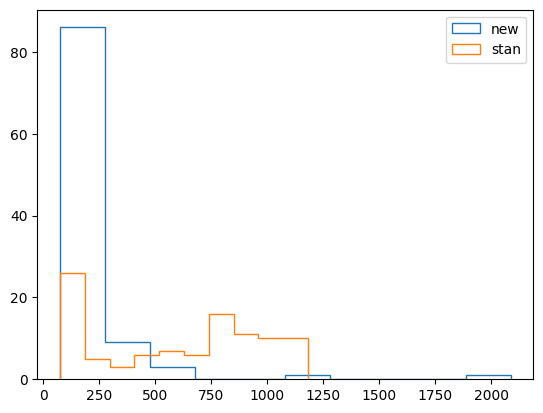

In [15]:
plt.hist(new_leapfrogs, histtype = "step", label = "new")
plt.hist(stan_leapfrogs, histtype = "step", label = "stan")
plt.legend()

In [22]:
mn = np.mean(new_leapfrogs)
ms = np.mean(stan_leapfrogs)
print(f"ratio of means: new_leapfrogs / stan_leapfrogs = {mn / ms}")

mdn = np.median(new_leapfrogs)
mds = np.median(stan_leapfrogs)
print(f"ratio of medians: new_leapfrogs / stan_leapfrogs = {mdn / mds}")

vn = np.var(new_leapfrogs)
vs = np.var(stan_leapfrogs)
print(f"ratio of vars: new_leapfrogs / stan_leapfrogs = {vn / vs}")

mnn = np.min(new_leapfrogs) 
mns = np.min(stan_leapfrogs)
print(f"ratio of mins: new_leapfrogs / stan_leapfrogs = {mnn / mns}")

mxn = np.max(new_leapfrogs) 
mxs = np.max(stan_leapfrogs)
print(f"ratio of maxs: new_leapfrogs / stan_leapfrogs = {mxn / mxs}")

z = np.array([-1.96, 1.96])
print("confidence interval of difference of mean leapfrogs, new - stan")
(mn - ms) + z * np.sqrt((vn + vs) / M)

ratio of means: new_leapfrogs / stan_leapfrogs = 0.3466292321493836
ratio of medians: new_leapfrogs / stan_leapfrogs = 0.2687224669603524
ratio of vars: new_leapfrogs / stan_leapfrogs = 0.3947647724036282
ratio of mins: new_leapfrogs / stan_leapfrogs = 1.0
ratio of maxs: new_leapfrogs / stan_leapfrogs = 1.7650042265426882
confidence interval of difference of mean leapfrogs, new - stan


array([-478.7769372, -307.8030628])

In [23]:
print(f"exclusive momentum based uturns: {np.sum(p_uturns)}")
print(f"exclusive position based uturns: {np.sum(q_uturns)}")
print(f"momentum and position based uturns: {np.sum(p_uturns) + np.sum(q_uturns) - np.sum(o_uturns)}")
print(f"momentum or position based uturns: {np.sum(o_uturns)}")

exclusive momentum based uturns: 5201.0
exclusive position based uturns: 184.0
momentum and position based uturns: 137.0
momentum or position based uturns: 5248.0


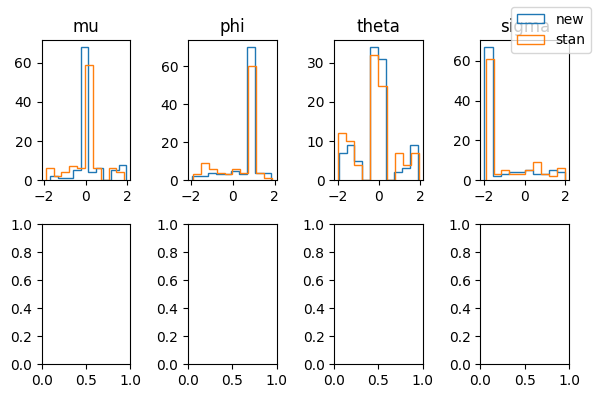

In [24]:
n_cols = 4
n_rows = np.divmod(dim, n_cols)[0] + 1
fig, axs = plt.subplots(n_rows, n_cols, figsize = (6, 4))
md = np.size(np.shape(axs))
param_names = bsm.param_names()

for d in range(dim):
    ir, ic = np.divmod(d, n_cols)
    ax = axs[ic] if md == 1 else axs[ir, ic]
    if d == 0:
        ax.hist(new_params[:, d], histtype = "step", label = "new", )
        ax.hist(stan_params[:, d], histtype = "step", label = "stan")
    else:
        ax.hist(new_params[:, d], histtype = "step")
        ax.hist(stan_params[:, d], histtype = "step")
    ax.title.set_text(param_names[d])
fig.tight_layout()
fig.legend()